## Generate 2D Projections with Angles

From the 3D protein structure, we want to generate 2D projections that were taken at different angles. This is done using the `cryoem` software tools implemented in this project that rely on [Astra Toolbox](https://github.com/astra-toolbox/astra-toolbox).

In this notebook we visualize the output of this generator. We have two main spaces we visualize the data:
- [$\mathbb{S}^2$ space]() which we use to represent the sampled directions. These directions represents at which angles the ray was sent through the protein. Imagine the protein in the center of the coordinate system and the potential ray positions cover the sphere around that protein with the fixed radius (i.e. only the border of the sphere is filled, the sphere itself is empty). It can also be described as camera positions around the protein. Only two angles $(\theta_2, \theta_1)$ represent the direction and they are used for visualization.
- [$\mathbf{SO}(3)$ space](https://en.wikipedia.org/wiki/3D_rotation_group) with the topology explained [here](https://en.wikipedia.org/wiki/3D_rotation_group#Topology). The possible positions fill the ball with radius that is in the range from $-\pi$ to $\pi$. For every point in this ball there is a rotation, with axis through the point and the origin, and rotation angle equal to the distance of the point from the origin. All three angles $(\theta_3, \theta_2, \theta_1)$ are used for the visualization.

Note: The goal of this project is to recover these positions of angles on the sphere only using the projections (images) not knowing the angle at which they were taken.

Following command line will be used to run the script for generating 2D projections with angles. Note: `cd ../..` is just locating into the root of this project. So if you run it in the root, you don't need it.

In [1]:
!python ../../generator.py --help

usage: generator.py [-h] [--config-file CONFIG_FILE] [--input-file INPUT_FILE]
                    [--projections-num PROJECTIONS_NUM]
                    [--angle-shift ANGLE_SHIFT]
                    [--angle-coverage ANGLE_COVERAGE]
                    [--angles-gen-mode ANGLES_GEN_MODE]
                    [--output-file OUTPUT_FILE]

Generator of 2D projections of 3D Cryo-Em volumes Args that start with '--'
(eg. --input-file) can also be set in a config file (protein.config or
specified via --config-file). Config file syntax allows: key=value, flag=true,
stuff=[a,b,c] (for details, see syntax at https://goo.gl/R74nmi). If an arg is
specified in more than one place, then commandline values override config file
values which override defaults.

optional arguments:
  -h, --help            show this help message and exit
  --config-file CONFIG_FILE, -conf CONFIG_FILE
                        Config file path
  --input-file INPUT_FILE, -in INPUT_FILE
                        Input file 

In [2]:
ROOT_DIR = "../.."

In [3]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [4]:
import os
import h5py
import numpy as np   

import sys
sys.path.append(ROOT_DIR) 
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9104503805025304740
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4465913311596276633
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7489435168140536522
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3288465408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15616205407199807074
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Full-Sphere Coverage - Uniform on $\mathbb{S}^2$ - 5K Projections

Generating the 5000 projection images that were taken from angles covering the full sphere around the protein. The sampling on the sphere is done uniformly on $\mathbb{S}^2$.

To generate simulation data of the protein, you can run the following command.
```
python generator.py --input-file data/5j0n.mrc -ang-gen uniform_angles -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 1.0 -cov 2.0
```
Note that the alternative way is just to change the config file `protein.config` with the modifications that you need. In that case it is sufficient to only run the following command:
```
python generator.py -conf protein.config
```

For every projection, we will have 3 angles, each representing the rotation around the corresponding axis. In our case we are dealing with $Z-Y-Z$ rotations:
- Z in $[0, 2\pi]$
- Y in $[0, \pi]$
- Z in $[0, 2\pi]$

In [17]:
!python ../../generator.py --input-file ../../data/5j0n.mrc --output-file ../../data/5j0n_full_uniformS2.h5 -ang-gen uniform_S2 -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 1.0 -cov 2.0

----------
Command Line Args:   --input-file ../../data/5j0n.mrc --output-file ../../data/5j0n_full_uniformS2.h5 -ang-gen uniform_S2 -num 5000 -shift 0.0 -shift 0.0 -shift 0.0 -cov 2.0 -cov 1.0 -cov 2.0

----------
* Loading the dataset *
Protein:         5j0n
Input filename:  ../../data/5j0n.mrc
Output filename: ../../data/5j0n_full_uniformS2.h5
Projections (#): (5000, 116, 116)
Angles (#):      (5000, 3)

**********


In [18]:
# half coverage (AngCoverage=0.5)
projections_filename = "../../data/5j0n_full_uniformS2.h5"

# load structures
data_full_5k_uniform = h5py.File(projections_filename, 'r')
angles2 = np.array(data_full_5k_uniform['Angles'], dtype=np.float32)
projections2 = np.array(data_full_5k_uniform['Projections'], dtype=np.float32)


print(f"{angles2.shape[0]} projections of images with dimension {projections2.shape[1:]} pixels")
print(f"{angles2.shape[0]} sets of {angles2.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


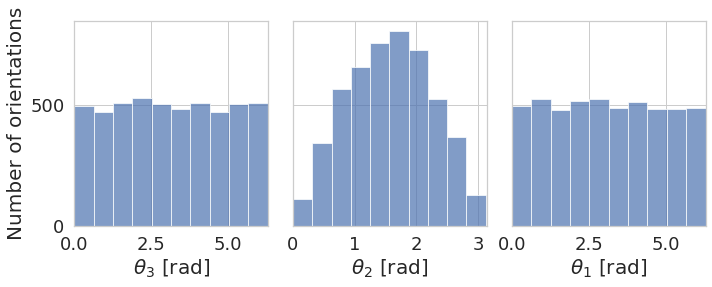

In [19]:
plot_angles_histogram([angles2], plot_settings=dict(figsize=(10, 4)))

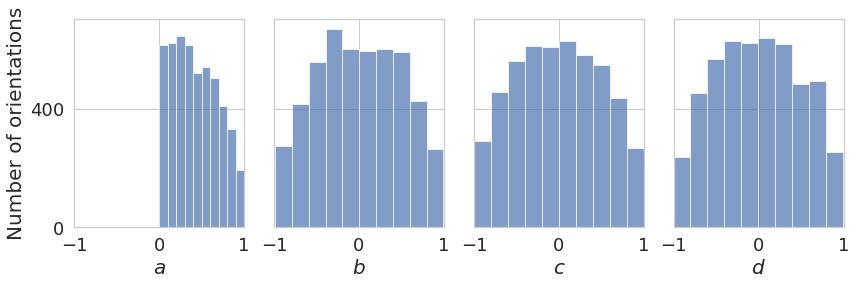

In [20]:
plot_quaternions_histogram([euler2quaternion(angles2)])

In [21]:
# pid = 0
# plot_projection(projections2[pid], f'Projection {pid}\nAngles {angles2[pid]}')

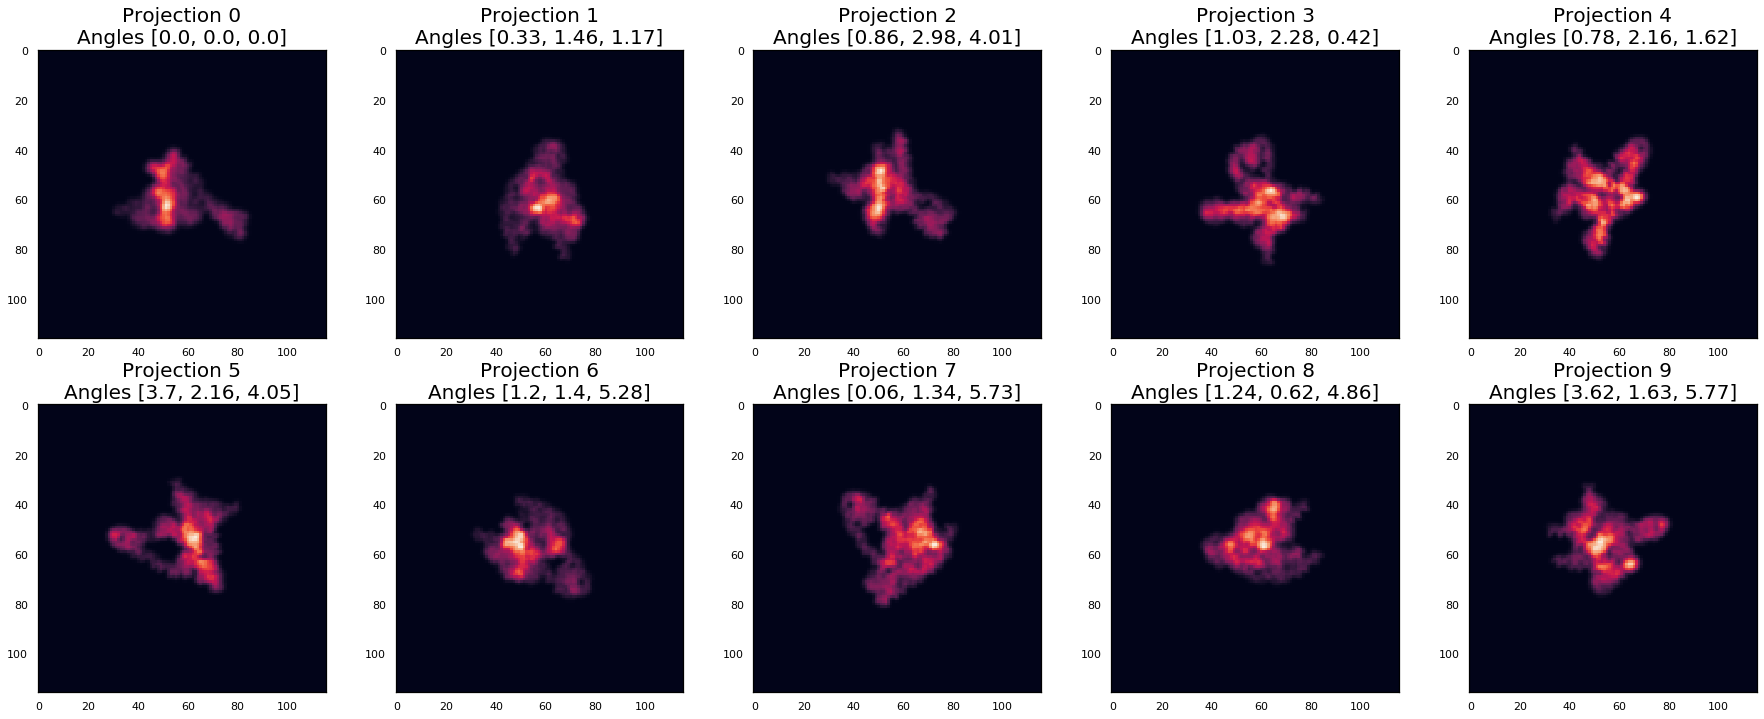

In [22]:
pids = range(10)
plot_projections(projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles1[pid]))}' for pid in pids], nrows=2, ncols=5)

In [23]:
plot_detector_pixels_with_protein(angles2, "../../data/5j0n.mrc", center=[34.88, 31.55, 39.82])

In [24]:
plot_images(angles2, projections2, indices=range(50), img_size_scale=0.15)

In [25]:
plot_rays(angles2, indices=range(50))